In [2]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv
import scanpy as sc
import pandas as pd
import collections
import numpy as np
import matplotlib
import networkx
import anndata
import network
import fsspec
import igraph
import scvi
import h5py
import desc 
import umap
import h5py
import os

%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)
plt.rcParams.update({'font.size': 9})
sc.set_figure_params(figsize=(2, 2), format = 'svg', dpi_save = 300)

python(51696) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` ins

... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS384-OS384.h5ad


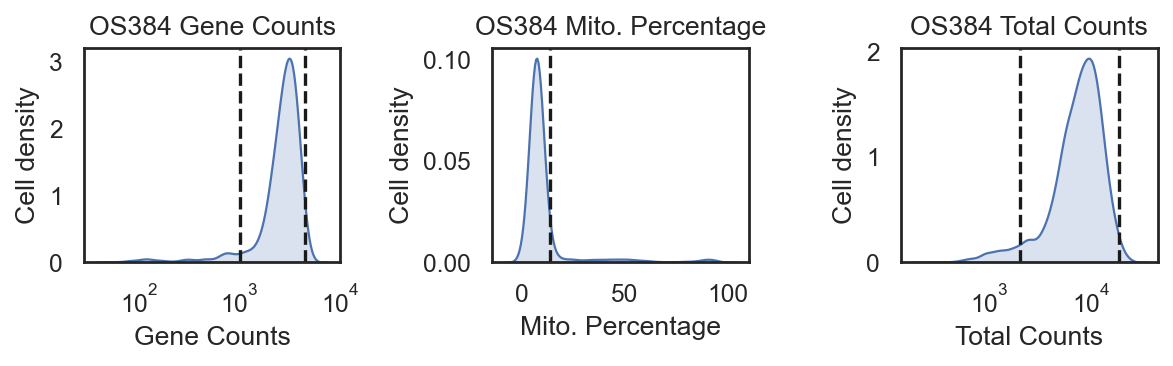

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


Filtered out 53345 genes that are detected 20 counts (shared).


In [2]:
# Reading in OS384 loom file
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS384/OS384.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Annotating mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Data for the variables
variables = [
    ('n_genes_by_counts', [(4500, '--'), (1000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(2000, '--'), (19000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS384 {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")

    
# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS384_filtering_plain.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# 
scv.pp.filter_genes(adata, min_shared_counts=20)


In [3]:


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
#scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)


# Log scaling
scv.pp.log1p(adata)


# Preserving the counts in counts layer
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# Creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

#genes = adata.var.index.values


# Reading in the cell cycle genes
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata


# Filtering adara object based on highly variable genes
adata = adata[:, adata.var.highly_variable]


sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])


sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

sc.tl.umap(adata)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_88999/2565411587.py:11: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


Normalized count data: X, spliced, unspliced.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html 

    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    725 total control genes are used. (0:00:00)
computing score 'G2M_score'


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'G2M_score', score of gene set (adata.obs).
    641 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/

    finished (0:00:10)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


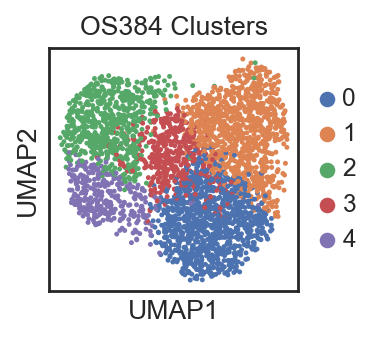

In [4]:

sc.tl.leiden(adata, resolution = 0.58) #0.6

# making the var names unique
adata.var_names_make_unique()


genes = adata.var.index.values


# Plotting the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS384 Clusters",
    size=20,
    show=False  # Do not display the plot immediately
)


# Save the plot as an SVG file
plt.savefig("/Users/brendamelano/Desktop/OS384_clusters.svg", format='svg', dpi=300)
plt.show()  

In [6]:

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_adata_leiden_PCA.h5ad")


# Reading in the state labeled adata object

<Axes: title={'center': 'OS384 States'}, xlabel='UMAP1', ylabel='UMAP2'>

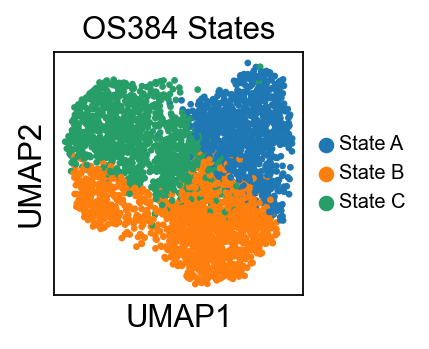

In [5]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_adata_subtype_PCA.h5ad")


# Plotting based on umap
sc.pl.umap(adata, color=['State'], legend_fontsize=9,
          title="OS384 States",
           show=False)


# Save the plot as an SVG file
#plt.savefig("/Users/brendamelano/Desktop/OS384_clusters.svg", format='svg', dpi=300)



In [4]:
adata.write_h5ad('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_adata_subtype_PCA.h5ad')


# Reading in df with leiden cluster labels

In [7]:
adata = sc.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_adata_leiden_PCA.h5ad")



In [ ]:
# data for mave

In [6]:
adata.write_h5ad('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/OS384_raw_filtered_feauture_bc_matrix.h5')


file_path = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/OS384_raw_filtered_feauture_bc_matrix.h5'

# Read the AnnData object
adata = sc.read_h5ad(file_path)

# Check the contents of the AnnData object
print(adata)            
print(adata.obs.head()) # Shows metadata associated with cells
print(adata.var.head()) # Shows metadata associated with genes

AnnData object with n_obs × n_vars = 3244 × 8196
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
                         n_genes_by_counts  total_counts  total_counts_mt  \
CellID                                                                      
OS384:AACAAGACATCGATGTx               1830        4209.0            431.0   
OS384:AAACGAATCATAGCACx               3692       11517.0            714.0   
OS384:AAAGAACTCTTCCTAAx               3211        8448.0            953.0   
OS384:AACCAACGTTACACACx               1305        2487.0            250.0   
OS384:AACAGGGAGTAAACGTx               2909        7243.0            741.0   

                         pct_counts_mt  initial_size_unspliced

In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import rpy2.robjects as ro
from scipy.io import mmwrite
from rpy2.robjects import pandas2ri

# Activate automatic pandas to R DataFrame conversion
pandas2ri.activate()

# Define the file path to your h5ad file
file_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/OS384_raw_filtered_feauture_bc_matrix.h5"

# Read the AnnData object
adata = sc.read_h5ad(file_path)

# Extract the count matrix, cell barcodes, and gene names
count_matrix = adata.X
cell_barcodes = adata.obs_names
gene_names = adata.var_names



# Save the count matrix in Matrix Market format
mmwrite('/Users/brendamelano/Desktop/plain_scRNAseq_analysis/files_for_rds_generation/OS384_count_matrix.mtx', count_matrix)

# Save cell barcodes and gene names
cell_barcodes.to_series().to_csv('/Users/brendamelano/Desktop/plain_scRNAseq_analysis/files_for_rds_generation/OS384_barcodes.tsv', sep='\t', index=False, header=False)
gene_names.to_series().to_csv('/Users/brendamelano/Desktop/plain_scRNAseq_analysis/files_for_rds_generation/OS384_genes.tsv', sep='\t', index=False, header=False)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


# Marker Visualization

In [3]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes


# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')


# Specified markers for visualization
specified_genes = ['UBE2C', 'AURKA', 'CENPF', 'AURKB', 'CKS2', 'TOP2A', 'CDK1', 'TUBB4B', 'ATAD2', 'H2AX']

# Ensure these genes are in the adata object
reduced_state_B_genes = [gene for gene in specified_genes if gene in adata.var_names]

plt.rcParams.update({'font.size': 12})

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + reduced_state_B_genes + Subtype_C_genes))


# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in reduced_state_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['State'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='State',
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 State Module Markers",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS384_subtype_markers.svg", format='svg')

plt.show()

plt.close()


ValueError: groupby has to be a valid observation. Given State, is not in observations: ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'S_score', 'G2M_score', 'phase', 'ccdifference', 'leiden'] or index name "CellID"

<Figure size 1200x300 with 0 Axes>

<Figure size 1200x300 with 0 Axes>

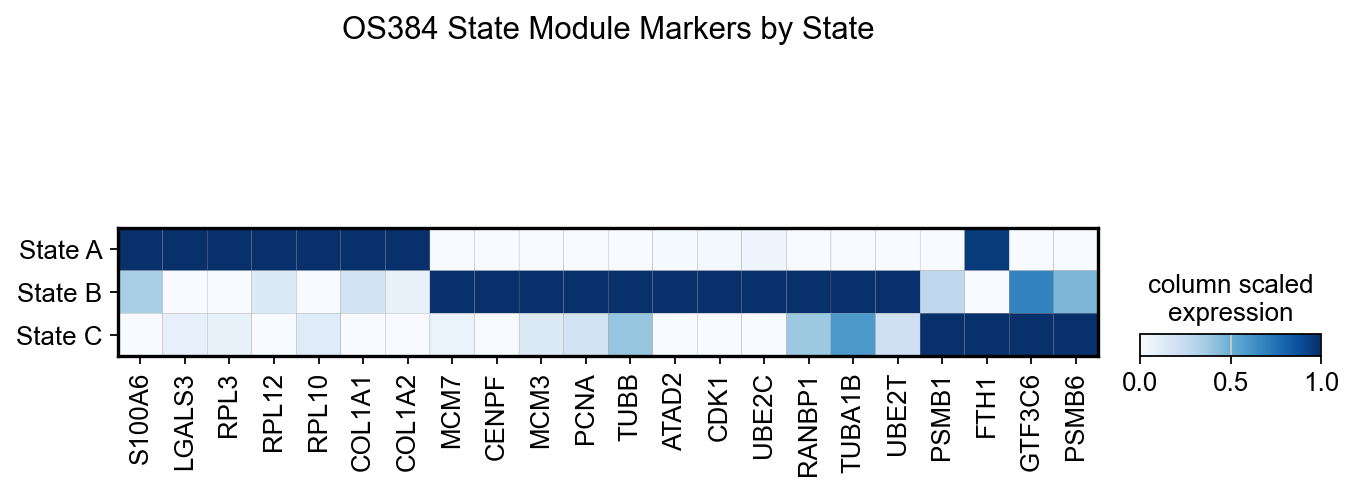

In [7]:

# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


# Plotting the matrix plot
ax = sc.pl.matrixplot(
    adata,
    var_names=combined_genes,  # Use the sorted list of genes
    groupby='State',
    cmap="Blues",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 State Module Markers by State",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS384_subtype_markers.svg", format='svg')

plt.show()

plt.close()


# Cluster level marker heatmap

In [15]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    import pandas as pd
    genes_df = pd.read_csv(file_path, header=0)  # Assuming the header is on the first row
    genes = genes_df.iloc[:, 0].tolist()  # Get the first column as a list
    return genes


# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')



plt.rcParams.update({'font.size': 12})

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes)

In [23]:
OS384_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_C_markers_NMF.csv', header=None)


#OS384_subtype_C_markers = OS384_subtype_C_markers.to_numpy()

In [8]:
# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]


<Figure size 1200x300 with 0 Axes>

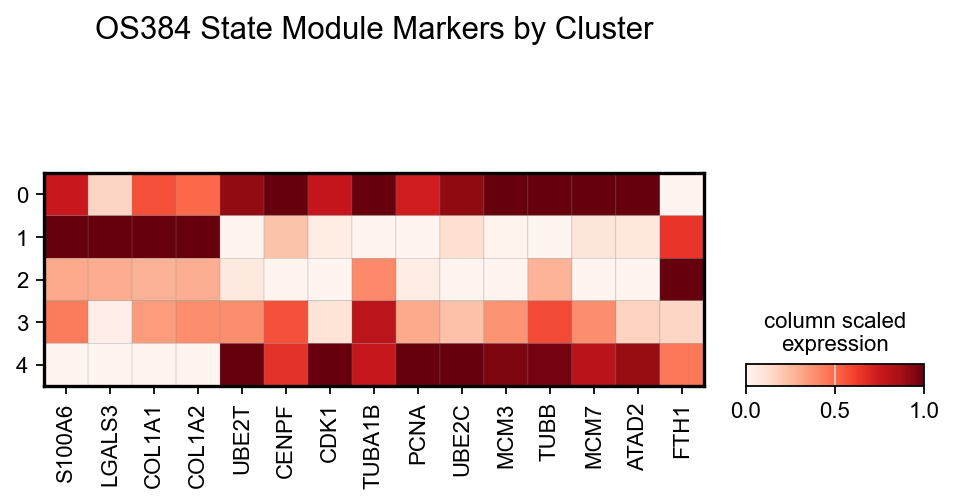

In [4]:


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in Subtype_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['State'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 State Module Markers by Cluster",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS384_cluster_markers.svg", format='svg')

plt.show()

plt.close()


In [4]:
Subtype_C_genes

['Gene', 'PSMB1', 'FTH1', 'GTF3C6', 'PSMB6']

In [6]:
combined_genes = list(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes)


In [5]:
combined_genes

['LGALS3',
 'COL1A2',
 'COL1A1',
 'S100A6',
 'MCM7',
 'CENPF',
 'MCM3',
 'PCNA',
 'TUBB',
 'ATAD2',
 'CDK1',
 'UBE2C',
 'TUBA1B',
 'UBE2T',
 'FTH1']

In [3]:
Subtype_A_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv', header=0)


Subtype_A_genes = Subtype_A_genes.to_numpy()



# Convert the set of tuples back to a list of lists (if necessary)
Subtype_A_genes = [list(gene) for gene in Subtype_A_genes]


Subtype_A_genes = np.array(Subtype_A_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_A_genes_df = pd.DataFrame(Subtype_A_genes, columns=['Gene'])

Subtype_A_genes = Subtype_A_genes_df['Gene']

Subtype_B_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv', header=0)


Subtype_B_genes = Subtype_B_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_B_genes = [list(gene) for gene in Subtype_B_genes]


Subtype_B_genes = np.array(Subtype_B_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_B_genes_df = pd.DataFrame(Subtype_B_genes, columns=['Gene'])

Subtype_B_genes = Subtype_B_genes_df['Gene']

In [4]:
Subtype_C_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv', header=0)


Subtype_C_genes = Subtype_C_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_C_genes = [list(gene) for gene in Subtype_C_genes]


Subtype_C_genes = np.array(Subtype_C_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_C_genes_df = pd.DataFrame(Subtype_C_genes, columns=['Gene'])

Subtype_C_genes = Subtype_C_genes_df['Gene']

In [5]:

# Function to process gene files through the pipeline
def process_genes(file_path):
    # Read file into a DataFrame
    genes = pd.read_csv(file_path, header=0)

    # Convert DataFrame to numpy array
    genes_array = genes.to_numpy()

    # Step 4: Convert set of tuples back to a list of lists
    genes_list = [list(gene) for gene in genes_array]

    # Step 5: Flatten the list of lists into a numpy array
    genes_flattened = np.array(genes_list).flatten()

    # Step 6: Convert numpy array to a pandas DataFrame
    genes_df = pd.DataFrame(genes_flattened, columns=['Gene'])

    return genes_df

# File paths for gene modules
file_paths = {
    "A": '/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv',
    "B": '/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv',
    "C": '/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv',
}



# Process each subtype and store results
processed_genes = {}
for key, path in file_paths.items():
    if os.path.exists(path):
        processed_genes[key] = process_genes(path)
    else:
        print(f"Skipping Subtype {key} due to missing file.")

# Output processed gene data for each subtype
for key, df in processed_genes.items():
    print(f"\nProcessed genes for Subtype {key}:")
    print(df)
    
    
# Concatenate all DataFrames into a single DataFrame
combined_genes_df = pd.concat(processed_genes.values(), ignore_index=True)

# View the combined DataFrame
print("\nCombined genes DataFrame:")
print(combined_genes_df)


Processed genes for Subtype A:
     Gene
0  S100A6
1  LGALS3
2    RPL3
3   RPL12
4   RPL10
5  COL1A1
6  COL1A2

Processed genes for Subtype B:
      Gene
0     MCM7
1    CENPF
2     MCM3
3     PCNA
4     TUBB
5    ATAD2
6     CDK1
7    UBE2C
8   RANBP1
9   TUBA1B
10   UBE2T

Processed genes for Subtype C:
     Gene
0   PSMB1
1    FTH1
2  GTF3C6
3   PSMB6

Combined genes DataFrame:
      Gene
0   S100A6
1   LGALS3
2     RPL3
3    RPL12
4    RPL10
5   COL1A1
6   COL1A2
7     MCM7
8    CENPF
9     MCM3
10    PCNA
11    TUBB
12   ATAD2
13    CDK1
14   UBE2C
15  RANBP1
16  TUBA1B
17   UBE2T
18   PSMB1
19    FTH1
20  GTF3C6
21   PSMB6


In [6]:
# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes_df['Gene'] if gene in adata.raw.var_names]



<Figure size 6000x3000 with 0 Axes>

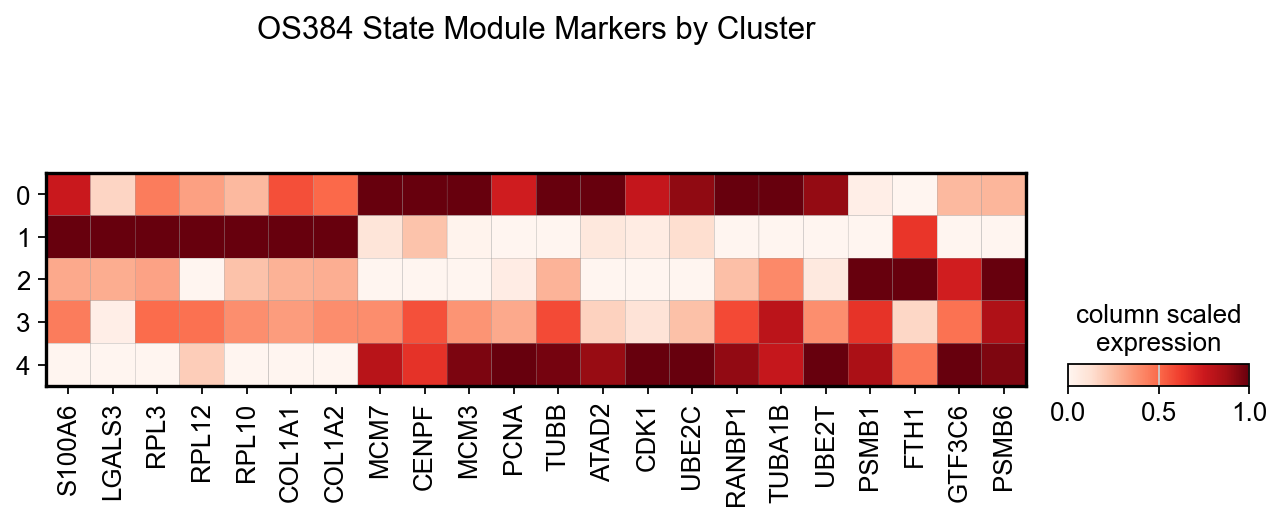

In [15]:


# Create a figure explicitly
plt.figure(figsize=(10, 5), dpi=600) 


ax = sc.pl.matrixplot(
    adata,
    var_names=combined_genes_df['Gene'],  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 State Module Markers by Cluster",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS384_cluster_markers.svg", format='svg')

plt.show()

plt.close()


# Identifying Subtype A markers

In [ ]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '1'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_A_markers

Subtype_A_genes_384 = cluster_markers.iloc[:, 1].tolist()

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_A_markers.csv", Subtype_A_genes_384, delimiter=",", fmt='%s')


# Subtype B marker identification

In [ ]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '0'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_B_markers

OS384_subtype_B_markers = OS384_subtype_B_markers.iloc[:, 0].tolist()

OS384_subtype_B_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_B_markers.csv", OS384_subtype_B_markers, delimiter=",", fmt='%s')


# Subtype C Marker identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '3'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_C_markers = OS384_subtype_C_markers.iloc[:, 0].tolist()

OS384_subtype_C_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_C_markers.csv", OS384_subtype_C_markers, delimiter=",", fmt='%s')


['AGBL1',
 'LINC02154',
 'DHRS2',
 'ENSG00000254337',
 'NECTIN3-AS1',
 'STMN2',
 'POSTN',
 'CSAG1',
 'IL13RA2',
 'COL8A1',
 'TNFRSF9',
 'LCP1',
 'KRT8',
 'FABP4',
 'TNNT1',
 'MME',
 'GREM1',
 'CDKN1C',
 'IGFBP5',
 'PRICKLE1',
 'HAPLN1',
 'BABAM2',
 'SUGCT',
 'S100A2',
 'LMCD1',
 'LUM',
 'TLE4',
 'SNAI2',
 'SBF2-AS1',
 'SNHG18',
 'CDA',
 'NUAK1',
 'RPS4X',
 'FTH1',
 'PHLDB2',
 'GPNMB',
 'ARID5B',
 'CCN2',
 'COL11A1',
 'DCBLD2',
 'PAWR',
 'PMEPA1',
 'FRMD6',
 'PDLIM1',
 'IFITM3',
 'TCEAL9',
 'TP53I3',
 'BNIP3',
 'IGF1R',
 'ITGA11',
 'FTL',
 'ENAH',
 'ZFP36L1',
 'FHL1',
 'LIMS1',
 'NNMT',
 'UBC',
 'TMSB4X',
 'TPM1',
 'H3-3B']

# State module enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    397 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


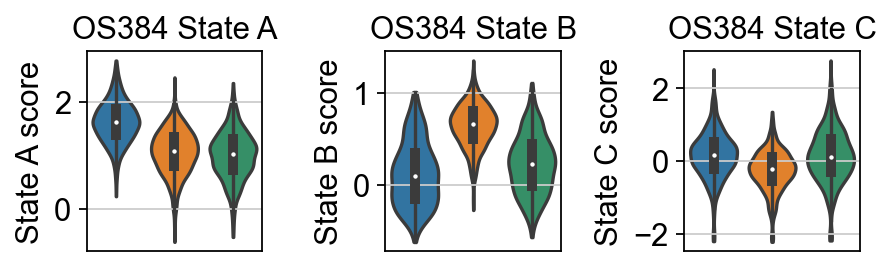

In [3]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], groupby='State', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)
axs[0].set_title('OS384 State A')

sc.pl.violin(adata, ['Subtype_B_score'], groupby='State', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)
axs[1].set_title('OS384 State B')

sc.pl.violin(adata, ['Subtype_C_score'], groupby='State', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('OS384 State C')

# Remove x-axis labels and tick labels
for ax in axs:
    ax.set_xlabel('')  # Remove x-axis labels
    ax.set_xticks([])  # Remove x-axis tick labels

plt.tight_layout()
plt.savefig('/Users/brendamelano/Desktop/OS384_gsea_scores.svg', format='svg')
plt.show()

# Label subtypes

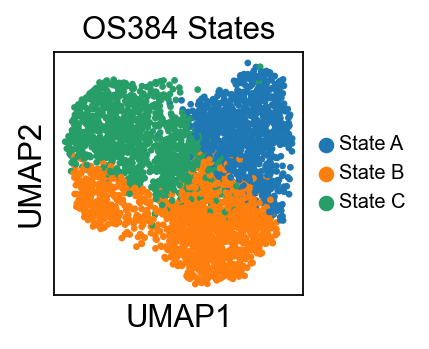

In [3]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='3']='2'
adata.obs['leiden'][adata.obs['leiden']=='4']='0'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'State A': ['1'],  'State B': ['0'], 'State C':['2']}


# Initialize empty column in cell metadata
adata.obs['State'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'State'] = i

    
# Creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['State'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


sc.pl.umap(adata, color=['State'], 
           legend_fontsize=9, 
           title = "OS384 States") #, palette = subtype_colors






In [4]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_adata_subtype_PCA.h5ad")


In [3]:
# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'State', method='wilcoxon')

# Creating a df for the cluster specific markers
state_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = 'State A'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_A_markers = OS384_subtype_A_markers.iloc[:, 0].tolist()

OS384_subtype_A_markers

np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_A_markers_NMF.csv", OS384_subtype_A_markers, delimiter=",", fmt='%s')


In [9]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = 'State B'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_B_markers = OS384_subtype_B_markers.iloc[:, 0].tolist()



np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_B_markers_NMF.csv", OS384_subtype_B_markers, delimiter=",", fmt='%s')


In [4]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = 'State C'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_C_markers = OS384_subtype_C_markers.iloc[:, 0].tolist()

OS384_subtype_C_markers

['AGBL1',
 'ENSG00000254337',
 'LINC02154',
 'CSAG1',
 'STMN2',
 'COL8A1',
 'FABP4',
 'KRT8',
 'TNNT1',
 'CDA',
 'LUM',
 'HAPLN1',
 'NUAK1',
 'SNAI2',
 'PTRHD1',
 'FHL1',
 'RPS4X',
 'LAMTOR5',
 'GSTP1',
 'FTH1',
 'RNF181',
 'SH3BGRL',
 'COX6B1',
 'ILF2',
 'GTF3C6',
 'PSMA5',
 'OAZ1',
 'KRT10',
 'LIMA1',
 'COX7B',
 'KDELR1',
 'UBB',
 'PSMB6',
 'PSMB1',
 'TPM1',
 'UBL5',
 'RHOC',
 'RPS26',
 'STRAP',
 'OST4',
 'HSP90AA1',
 'TMSB4X',
 'RPL36AL',
 'PTMS',
 'SUB1',
 'ANXA2',
 'SRP14',
 'S100A11',
 'POMP',
 'EID1',
 'ACTG1',
 'YWHAB',
 'SF3B6',
 'PSMD8',
 'ACTB',
 'RPS19',
 'RPS15',
 'TMSB10',
 'ATP5F1E',
 'GAPDH']

In [ ]:


np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_C_markers_NMF.csv", OS384_subtype_C_markers, delimiter=",", fmt='%s')


# Exporting tsv with cell barcode and subtype for MAVE

In [3]:
from argparse import ArgumentParser
import numpy as np
import os
import pandas as pd
import pysam

In [4]:
def generate_tsv_from_anndata(adata, tsv_output_path, meta_col="State"):
    # Use adata.obs.index for barcodes
    barcodes = adata.obs.index
    
    # Clean the barcodes to remove prefix and suffix and add '-1' suffix
    barcodes = barcodes.str.replace(r'^OS384:', '', regex=True).str.replace(r'x$', '', regex=True) + '-1'
    cell_types = adata.obs[meta_col]
    df = pd.DataFrame({'Barcode': barcodes, meta_col: cell_types})
    df.to_csv(tsv_output_path, sep='\t', index=False)
    print(f"TSV file saved to {tsv_output_path}")
    
    
# Defining the directory in which to save the tsv
tsv_output_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_state.tsv"
generate_tsv_from_anndata(adata, tsv_output_path)

TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_state.tsv


In [6]:



# Read the TSV file into a DataFrame
df = pd.read_csv(tsv_output_path, sep='\t')
df


# Splitting the BAM files
def split_bam(bamobj, dict_cells):
    dict_barcodes = {}
    for celltype in dict_cells.keys():
        print(f"Extracting {celltype} barcodes")
        barcodes = dict_cells[celltype]["barcodes"]
        for barcode in barcodes:
            dict_barcodes[barcode] = celltype
    barcodes = np.array(list(dict_barcodes.keys()))
    numreads = 0
    numaddedreads = 0
    for read in bamobj:
        cellbarcode = "0"
        for k in range(len(read.tags)):
            if read.tags[k][0] == "CB":
                cellbarcode = read.tags[k][1]
        if cellbarcode != "0":
            barcode_exists = cellbarcode in barcodes
            good_qual = read.mapq > 10
            if barcode_exists and good_qual:
                celltype = dict_barcodes[cellbarcode]
                dict_cells[celltype]["bamobj"].write(read)
                numaddedreads += 1
        if numreads % 500000 == 0:
            print(f"{numreads} reads analyzed, {numaddedreads} added")
        numreads += 1

def main(bampath, outdir, barcodepath, meta_col, samplename):
    bamobj = pysam.AlignmentFile(bampath, "rb")
    metadf = pd.read_csv(barcodepath, sep="\t")
    metadf = metadf[metadf[meta_col] == samplename]
    adname = samplename.replace(" ", "_")
    outpath = os.path.join(outdir, f"{adname}.bam")
    adobj = pysam.AlignmentFile(outpath, "wb", template=bamobj)
    dict_cells = {
        samplename: {
            "barcodes": np.array(metadf["Barcode"]),
            "bampath": outpath,
            "bamobj": adobj}}
    split_bam(bamobj, dict_cells)
    for celltype in pd.unique(metadf[meta_col]):
        dict_cells[celltype]["bamobj"].close()
    bamobj.close()
    

BAMPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_possorted_genome_bam.bam" #"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/possorted_genome_bam.bam"
OUTDIR = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs"
BARCODEPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_subtype.tsv"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/OS152_10Xbarcode_subtype.tsv"
Subtypes = ["State A", "State B", "State C"]


for CELLTYPE in Subtypes:
    main(BAMPATH, OUTDIR, BARCODEPATH, "State", CELLTYPE)

TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_subtype.tsv
Extracting State A barcodes
0 reads analyzed, 0 added
500000 reads analyzed, 148985 added
1000000 reads analyzed, 305453 added
1500000 reads analyzed, 460217 added
2000000 reads analyzed, 617599 added
2500000 reads analyzed, 777027 added
3000000 reads analyzed, 927381 added
3500000 reads analyzed, 1083519 added
4000000 reads analyzed, 1210747 added
4500000 reads analyzed, 1353402 added
5000000 reads analyzed, 1499937 added
5500000 reads analyzed, 1650777 added
6000000 reads analyzed, 1797603 added
6500000 reads analyzed, 1950100 added
7000000 reads analyzed, 2117164 added
7500000 reads analyzed, 2278812 added
8000000 reads analyzed, 2430565 added
8500000 reads analyzed, 2579370 added
9000000 reads analyzed, 2720938 added
9500000 reads analyzed, 2869443 added
10000000 reads analyzed, 3015776 added
10500000 reads analyzed, 3158342 added
11000000 reads analyz

19000000 reads analyzed, 6739452 added
19500000 reads analyzed, 6916286 added
20000000 reads analyzed, 7096003 added
20500000 reads analyzed, 7264153 added
21000000 reads analyzed, 7438305 added
21500000 reads analyzed, 7615448 added
22000000 reads analyzed, 7793111 added
22500000 reads analyzed, 7970616 added
23000000 reads analyzed, 8144814 added
23500000 reads analyzed, 8325500 added
24000000 reads analyzed, 8498294 added
24500000 reads analyzed, 8671756 added
25000000 reads analyzed, 8851248 added
25500000 reads analyzed, 9036216 added
26000000 reads analyzed, 9198487 added
26500000 reads analyzed, 9375562 added
27000000 reads analyzed, 9559176 added
27500000 reads analyzed, 9740263 added
28000000 reads analyzed, 9921940 added
28500000 reads analyzed, 10103819 added
29000000 reads analyzed, 10238897 added
29500000 reads analyzed, 10407463 added
30000000 reads analyzed, 10583268 added
30500000 reads analyzed, 10765150 added
31000000 reads analyzed, 10938791 added
31500000 reads anal

39500000 reads analyzed, 5995098 added
40000000 reads analyzed, 6077703 added
40500000 reads analyzed, 6153024 added
41000000 reads analyzed, 6238230 added
41500000 reads analyzed, 6312932 added
42000000 reads analyzed, 6391100 added
42500000 reads analyzed, 6468716 added
43000000 reads analyzed, 6540543 added
43500000 reads analyzed, 6612989 added
44000000 reads analyzed, 6687816 added
44500000 reads analyzed, 6761422 added
45000000 reads analyzed, 6828197 added
45500000 reads analyzed, 6902902 added
46000000 reads analyzed, 6970521 added
46500000 reads analyzed, 7047969 added
47000000 reads analyzed, 7128421 added
47500000 reads analyzed, 7209667 added
48000000 reads analyzed, 7262013 added
48500000 reads analyzed, 7343031 added
49000000 reads analyzed, 7413526 added
49500000 reads analyzed, 7486264 added
50000000 reads analyzed, 7561793 added
50500000 reads analyzed, 7636685 added
51000000 reads analyzed, 7715368 added
51500000 reads analyzed, 7799330 added
52000000 reads analyzed, 

# Producing bai files

In [1]:
import pysam

bam_files = [
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/State_A.bam",
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/State_B.bam",
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/State_C.bam"
]

for bam_file in bam_files:
    pysam.index(bam_file)

# RNA velocity with scVelo

In [6]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)


# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/551 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

    finished (0:02:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3244 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


saving figure to file ./figures/scvelo_OS384_velocity_embedding_stream.svg


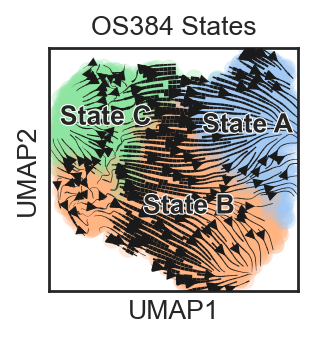

In [8]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='State', 
                                 palette=colors, 
                                 rasterized=True,
                                 title = 'OS384 States',
                                 frameon = True,
                                 save='OS384_velocity_embedding_stream.svg')


# GSEA

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    198 total control genes are used. 

    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'
    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_s

    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)


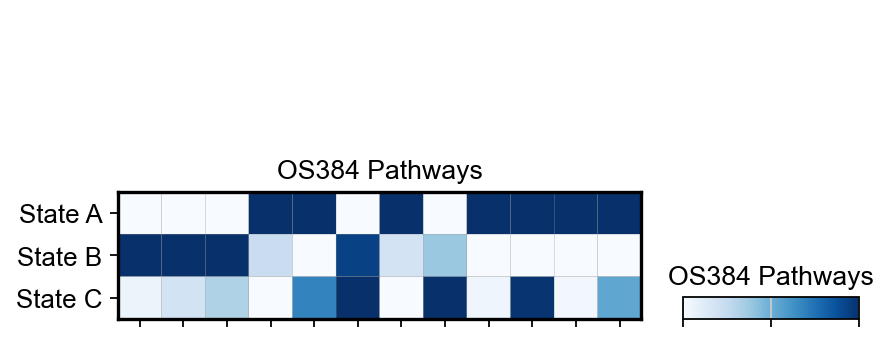

In [8]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

            
# Create a dictionary to store gene scores for each module
gene_scores = {}


# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
adata.var_names_make_unique()


# Defining the score names
scores = [ 'MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score','ESC_genes_score','TNFA_genes_score','PDGF_ERK1_DOWN_genes_score',   
          'KRAS_genes_score', 'TGFB_genes_score','IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score',]


# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "State",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)


# Remove the x-axis labels
for ax in axes_dict.values():
    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_title('OS384 Pathways', fontsize=12)

    
# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS384_Pathways.svg', format='svg')  # Adjust path as needed

# Show the plot if desired
plt.show()

# G1 cell proportions

In [4]:
# Generate and save the first rasterized UMAP plot with fontsize 12
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title='OS384 Cell Cycle classification',
    show=False  # Prevent the plot from displaying in the interactive window
)

# Set tick label font sizes to 12 and adjust the title font size
fig = plt.gcf()
ax = plt.gca()

# Set title font size
ax.set_title(ax.get_title(), fontsize=12)

# Set axis labels and tick label font sizes
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Ensure rasterization for compatibility
for collection in ax.collections:
    collection.set_rasterized(True)
fig.savefig("/Users/brendamelano/Desktop/OS384_phase_umap.svg", format='svg')
plt.close(fig)

# Generate and save the second rasterized UMAP plot with fontsize 12
sc.pl.umap(
    adata,
    color=["State_A_score"],
    frameon=True,
    title='OS384 State A Score UMAP',
    show=False
)

fig = plt.gcf()
ax = plt.gca()

# Set title and label font sizes
ax.set_title(ax.get_title(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

for collection in ax.collections:
    collection.set_rasterized(True)
fig.savefig("/Users/brendamelano/Desktop/OS384_state_A_score_umap.svg", format='svg')
plt.close(fig)

# Perform chi-squared analysis
# Small constant to avoid zero counts in the contingency table
epsilon = 1e-5
obs_data = adata.obs

# Create a contingency table
# Rows: phase status
# Columns: Inside or outside Subtype A
contingency_table = pd.DataFrame(
    [
        [
            ((obs_data['phase'] == 'G1') & (obs_data['State'] == 'State A')).sum(),  # True in Subtype A
            ((obs_data['phase'] == 'G1') & (obs_data['State'] != 'State A')).sum(),  # True outside Subtype A
        ],
        [
            ((obs_data['phase'] != 'G1') & (obs_data['State'] == 'State A')).sum(),  # False in Subtype A
            ((obs_data['phase'] != 'G1') & (obs_data['State'] != 'State A')).sum(),  # False outside Subtype A
        ],
    ],
    index=["Phase_G1", "Phase_other"],
    columns=["State A", "Other State"]
)

# Add small constant to avoid issues with zeros
contingency_table += epsilon

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Set a significance threshold
significance_threshold = 0.05

# Check if the result is significant
is_significant = p < significance_threshold

print(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Significant: {'Yes' if is_significant else 'No'}")

# Calculate the proportions of G1 cells within State A and outside of State A
Subtype_A_G1 = obs_data[(obs_data['State'] == 'State A') & (obs_data['phase'] == 'G1')]
Subtype_A_all = obs_data[obs_data['State'] == 'State A']

Subtype_B_C_G1 = obs_data[(obs_data['State'] != 'State A') & (obs_data['phase'] == 'G1')]
Subtype_B_C_all = obs_data[obs_data['State'] != 'State A']

prop_in_Subtype_A = len(Subtype_A_G1) / len(Subtype_A_all)
prop_outside_Subtype_A = len(Subtype_B_C_G1) / len(Subtype_B_C_all)


# Data to plot
categories = ['State A', 'States B and C']
proportions = [prop_in_Subtype_A, prop_outside_Subtype_A]


# Create and save the rasterized bar chart
plt.figure(figsize=(3.5, 3.5))
bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])  # pastel blue and pink

# Add a border around the chart
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

# Remove gridlines
plt.grid(False)

# Add labels and title
plt.ylabel('Proportion of cells in G1 state', fontsize=12)
plt.title('OS384 Proportion of G1 cells', fontsize=12)

# Add p-value to the top right of the plot
plt.text(1, max(proportions) * 0.95, f'p-value: {p:.2e}', ha='right', fontsize=12)

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2%}', va='bottom', fontsize=12)  # va: vertical alignment, percentage formatting

plt.tight_layout()
plt.savefig("/Users/brendamelano/Desktop/OS384_G1_proportion.svg", format='svg')
plt.close()

               State A  Other State
Phase_G1     603.00001    602.00001
Phase_other  305.00001   1734.00001
Chi2: 460.7744594231588
P-value: 3.2610377478253154e-102
Significant: Yes
